# Experimenting with transfer learning using NLP model

Outline of experiment in this document:
* Data - WISDM Smartphone and Smartwatch Activity and Biometrics Dataset Data Set:
    * https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+
    * The raw accelerometer and gyroscope sensor data is collected from the smartphone and smartwatch at a rate of 20Hz
    * 51 test subjects as they perform 18 activities for 3 minutes apiece
* Experiment 1: Word2vec NLP for transfer learning with voronoi
    * Steps:
        * Load Watch data
        * Compute transform on data: Here simple downsample. Calculate mean of (x,y,z) over specific time interval
        * Cluster Data using kmean - Vocab = cluser labels
        * Create "sentences using cluster data"
            * A senteces ex: X1,X2,X3,X4,X5 --> "3 4 7 7 7"
        * There are 18 activity labels so convert to binary -> (activive , non active)
        * Run Word2Vec model to obtain word features (cluster vectors) "3" -> X^d
        * Run Logistic Regression for baseline - For cliend 1600 - 66% - in sample
        * Run Voronoi - 89% - in sample
* TODO: Run on all clients and run with in / out sample
* TODO: Run transform model instead of word2vec

In [1]:
# DO FFT - transform
# Make sure to have a holdout set - never see this the whole way
# Think about better feature transform, larger feature set, maybe parkinsons specific?, Amplitude, simple feature from fft, power spectrum, intensity

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
os.chdir('../')

In [4]:
from Wearables.wisdm import WisdmData

In [5]:
data_path = "/Users/davidsewell/MLData/"

In [6]:
wisdm_data = WisdmData(data_path)

Could not process id for file .DS_Store


In [9]:
watch_data = wisdm_data.load_subject_data(subject_id=1600,device_type="watch",data_type="accel")

In [10]:
watch_data.head()

,subject_id,activity_code,unix,x,y,z
0,1600,A,90426708196641,7.091625,-0.591667,8.195502
1,1600,A,90426757696641,4.972757,-0.158317,6.696732
2,1600,A,90426807196641,3.253720,-0.191835,6.107758
3,1600,A,90426856696641,2.801216,-0.155922,5.997625
4,1600,A,90426906196641,3.770868,-1.051354,7.731027


In [11]:
watch_data.shape

(65462, 6)

In [12]:
watch_data['datetime'] = pd.to_datetime(watch_data['unix'])

In [13]:
watch_data['datetime'].min() , watch_data['datetime'].max()

(Timestamp('1970-01-01 22:10:17.308824838'),
 Timestamp('1970-01-02 01:42:50.102257932'))

In [14]:
tot_time = watch_data['datetime'].max() - watch_data['datetime'].min()

In [15]:
watch_data.shape[0] / tot_time.seconds

5.133469259723965

In [16]:
tot_time.seconds / 30.0

425.06666666666666

In [17]:
tot_time.seconds / (3600.0)

3.542222222222222

In [18]:
watch_data = watch_data.drop('unix',axis=1)

In [19]:
watch_data.head()

,subject_id,activity_code,x,y,z,datetime
0,1600,A,7.091625,-0.591667,8.195502,1970-01-02 01:07:06.708196641
1,1600,A,4.972757,-0.158317,6.696732,1970-01-02 01:07:06.757696641
2,1600,A,3.253720,-0.191835,6.107758,1970-01-02 01:07:06.807196641
3,1600,A,2.801216,-0.155922,5.997625,1970-01-02 01:07:06.856696641
4,1600,A,3.770868,-1.051354,7.731027,1970-01-02 01:07:06.906196641


In [20]:
set(watch_data['activity_code'])

{'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'O',
 'P',
 'Q',
 'R',
 'S'}

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

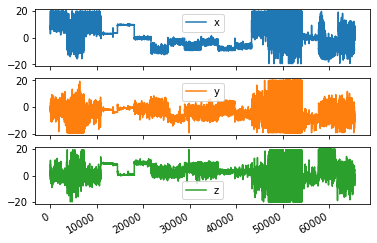

In [21]:
watch_data[['x','y','z']].plot(subplots=True)

In [22]:
watch_data = watch_data.set_index('datetime')

In [30]:
watch_data.columns

Index(['subject_id', 'activity_code', 'x', 'y', 'z'], dtype='object')

In [36]:
down2 = watch_data.groupby('subject_id').resample('5s').mean().dropna()

In [51]:
down2.index.get_level_values(0)

Int64Index([1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600,
            ...
            1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600],
           dtype='int64', name='subject_id', length=666)

In [52]:
down2['subject'] = down2.index.get_level_values(0)

In [53]:
down2

subject_id         x         y         z  \
subject_id datetime                                                        
1600       1970-01-01 22:10:15      1600.0  2.219060 -0.877181  9.689364   
           1970-01-01 22:10:20      1600.0  2.931760 -1.670458  9.175952   
           1970-01-01 22:10:25      1600.0  2.937422 -1.654897  9.188616   
           1970-01-01 22:10:30      1600.0  2.943252 -1.569615  9.204060   
           1970-01-01 22:10:35      1600.0  2.895176 -1.589822  9.219454   
...                                    ...       ...       ...       ...   
           1970-01-02 01:42:30      1600.0 -9.012948 -1.509269  2.525458   
           1970-01-02 01:42:35      1600.0 -8.887133 -2.041907  2.762699   
           1970-01-02 01:42:40      1600.0 -9.218467 -0.990613  2.013625   
           1970-01-02 01:42:45      1600.0 -9.087432 -2.430989  1.265557   
           1970-01-02 01:42:50      1600.0 -7.648676  1.049957  3.716749   

                                subject  
subject_id datetime                      
1600       1970-01-01 22:10:15     1600  
           1970-01-01 22:10:20     1600  
           1970-01-01 22:10:25     1600  
           1970-01-01 22:10:30     1600  
           1970-01-01 22:10:35     1600  
...                                 ...  
           1970-01-02 01:42:30     1600  
           1970-01-02 01:42:35     1600  
           1970-01-02 01:42:40     1600  
           1970-01-02 01:42:45     1600  
           1970-01-02 01:42:50     1600  

[666 rows x 5 columns]

In [48]:
down2.index[:].to_numpy().

(666,)

In [23]:
downsampled_data = watch_data.resample('5S').mean()

In [24]:
downsampled_data.shape

(2552, 4)

In [25]:
downsampled_data.head()

,subject_id,x,y,z
datetime,,,,
1970-01-01 22:10:15,1600.0,2.219060,-0.877181,9.689364
1970-01-01 22:10:20,1600.0,2.931760,-1.670458,9.175952
1970-01-01 22:10:25,1600.0,2.937422,-1.654897,9.188616
1970-01-01 22:10:30,1600.0,2.943252,-1.569615,9.204060
1970-01-01 22:10:35,1600.0,2.895176,-1.589822,9.219454


In [26]:
downsampled_data = downsampled_data.dropna()

In [27]:
downsampled_data.shape

(666, 4)

In [28]:
downsampled_data.head()

,subject_id,x,y,z
datetime,,,,
1970-01-01 22:10:15,1600.0,2.219060,-0.877181,9.689364
1970-01-01 22:10:20,1600.0,2.931760,-1.670458,9.175952
1970-01-01 22:10:25,1600.0,2.937422,-1.654897,9.188616
1970-01-01 22:10:30,1600.0,2.943252,-1.569615,9.204060
1970-01-01 22:10:35,1600.0,2.895176,-1.589822,9.219454


In [33]:
def assign_activity(times,df):
    
    activities = []
    for i in range(len(times) - 1):
        min_ = times[i]
        max_ = times[i + 1]
        set_activity = list(set(df[(df.index >= min_) & (df.index <= max_) ]['activity_code']))
        if len(set_activity) > 1:
            print("OH No More than one activity")
            print(f"MIN:{min_}, MAX:{max_}")
            print(set_activity)
            return
        elif len(set_activity) == 0:
            print("0 len")
            print(f"MIN:{min_}, MAX:{max_}")
            print(set_activity)
            print(i)
            return
        else:
            activities.append(set_activity[0])
    
    set_activity = list(set(df[(df.index >= times[-1])]['activity_code']))
    if len(set_activity) > 1:
        print("OH No More than one activity")
        print(f"MIN:{min_}, MAX:{max_}")
        print(set_activity)
        return
    elif len(set_activity) == 0:
        print("0 len")
        print(f"MIN:{min_}, MAX:{max_}")
        print(set_activity)
        return
    activities.append(set_activity[0])
    return activities
    
    

In [34]:
downsampled_data['activity'] = assign_activity(downsampled_data.index,watch_data)

In [35]:
downsampled_data.head()

,subject_id,x,y,z,activity
datetime,,,,,
1970-01-01 22:10:15,1600.0,2.219060,-0.877181,9.689364,D
1970-01-01 22:10:20,1600.0,2.931760,-1.670458,9.175952,D
1970-01-01 22:10:25,1600.0,2.937422,-1.654897,9.188616,D
1970-01-01 22:10:30,1600.0,2.943252,-1.569615,9.204060,D
1970-01-01 22:10:35,1600.0,2.895176,-1.589822,9.219454,D


array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>], dtype=object)

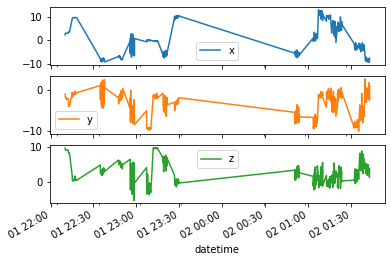

In [36]:
downsampled_data[['x','y','z']].plot(subplots=True)

In [37]:
downsampled_data['datetime'] = downsampled_data.index

In [38]:
downsampled_data['activity_start'] = downsampled_data.groupby(by="activity")['datetime'].transform('min')
downsampled_data['activity_end'] = downsampled_data.groupby(by="activity")['datetime'].transform('max')

In [39]:
list(set(downsampled_data['activity_start']))

[Timestamp('1970-01-02 01:16:20'),
 Timestamp('1970-01-02 01:32:10'),
 Timestamp('1970-01-02 01:03:25'),
 Timestamp('1970-01-01 22:10:15'),
 Timestamp('1970-01-01 23:11:45'),
 Timestamp('1970-01-01 22:15:10'),
 Timestamp('1970-01-02 00:50:50'),
 Timestamp('1970-01-02 01:36:00'),
 Timestamp('1970-01-01 22:55:40'),
 Timestamp('1970-01-01 23:18:30'),
 Timestamp('1970-01-02 01:07:05'),
 Timestamp('1970-01-02 01:12:40'),
 Timestamp('1970-01-02 01:20:25'),
 Timestamp('1970-01-02 01:39:50'),
 Timestamp('1970-01-01 23:07:05'),
 Timestamp('1970-01-01 22:47:25'),
 Timestamp('1970-01-01 23:26:35'),
 Timestamp('1970-01-01 22:34:45')]

In [41]:
downsampled_data[['activity','activity_start','activity_end']]

,activity,activity_start,activity_end
datetime,,,
1970-01-01 22:10:15,D,1970-01-01 22:10:15,1970-01-01 22:13:15
1970-01-01 22:10:20,D,1970-01-01 22:10:15,1970-01-01 22:13:15
1970-01-01 22:10:25,D,1970-01-01 22:10:15,1970-01-01 22:13:15
1970-01-01 22:10:30,D,1970-01-01 22:10:15,1970-01-01 22:13:15
1970-01-01 22:10:35,D,1970-01-01 22:10:15,1970-01-01 22:13:15
...,...,...,...
1970-01-02 01:42:30,G,1970-01-02 01:39:50,1970-01-02 01:42:50
1970-01-02 01:42:35,G,1970-01-02 01:39:50,1970-01-02 01:42:50
1970-01-02 01:42:40,G,1970-01-02 01:39:50,1970-01-02 01:42:50


In [29]:
#bins = np.linspace(int(downsampled_data['z'].min()) ,int(downsampled_data['z'].max()),num=30)

In [30]:
#plt.hist(np.digitize(downsampled_data['z'],bins))

In [31]:
#downsampled_data['bin_z'] = np.digitize(downsampled_data['z'],bins)

Now cluster so each (x,y,z) data point will correspond to given cluster

That cluster will be our "word"

In [42]:
from sklearn.cluster import KMeans

In [43]:
kmeans = KMeans(n_clusters=30)

In [44]:
X, y = downsampled_data[['x','y','z']].to_numpy() , downsampled_data['activity'].to_numpy()

In [45]:
def convert_binary_class(response,target):
    binary = np.zeros(len(response))
    binary[np.where(np.isin(response,target))] = 1
    return binary

In [46]:
target = ['A','B','C','M','O','R']

In [47]:
y = convert_binary_class(y,target)

In [48]:
kmeans.fit(X)

KMeans(n_clusters=30)

In [49]:
downsampled_data['cluster'] = kmeans.labels_

<AxesSubplot:>

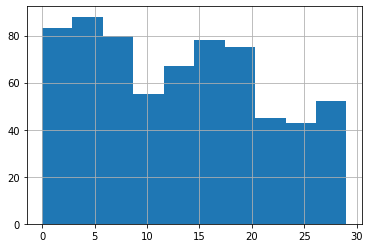

In [50]:
downsampled_data['cluster'].hist()

In [51]:
# Run Log regression for baseline
from sklearn.linear_model import LogisticRegression

In [52]:
lr = LogisticRegression()

In [53]:
X

array([[ 2.2190604 , -0.8771811 ,  9.68936419],
       [ 2.93175989, -1.67045849,  9.17595168],
       [ 2.93742183, -1.65489712,  9.18861574],
       ...,
       [-9.21846662, -0.99061293,  2.01362538],
       [-9.08743192, -2.43098862,  1.26555707],
       [-7.6486764 ,  1.04995717,  3.71674867]])

In [54]:
lr.fit(X,y)

LogisticRegression()

In [55]:
lr.score(X,y)

0.7822822822822822

In [56]:
downsampled_data.head()

,subject_id,x,y,z,activity,datetime,activity_start,activity_end,cluster
datetime,,,,,,,,,
1970-01-01 22:10:15,1600.0,2.219060,-0.877181,9.689364,D,1970-01-01 22:10:15,1970-01-01 22:10:15,1970-01-01 22:13:15,3
1970-01-01 22:10:20,1600.0,2.931760,-1.670458,9.175952,D,1970-01-01 22:10:20,1970-01-01 22:10:15,1970-01-01 22:13:15,3
1970-01-01 22:10:25,1600.0,2.937422,-1.654897,9.188616,D,1970-01-01 22:10:25,1970-01-01 22:10:15,1970-01-01 22:13:15,3
1970-01-01 22:10:30,1600.0,2.943252,-1.569615,9.204060,D,1970-01-01 22:10:30,1970-01-01 22:10:15,1970-01-01 22:13:15,3
1970-01-01 22:10:35,1600.0,2.895176,-1.589822,9.219454,D,1970-01-01 22:10:35,1970-01-01 22:10:15,1970-01-01 22:13:15,3


In [63]:
def pd_to_sentence(df,target):
    sentences = []
    activities = list(set(df['activity']))
    for a in activities:
        sub = df[df['activity'] == a]
        sentences.append([' '.join(list(sub['cluster'].apply(lambda x: str(x)))),a,1 if (a in target) else 0])
    return pd.DataFrame(sentences,columns=['text','activity','target'])
    


In [64]:
train_text  = pd_to_sentence(downsampled_data,target)

In [65]:
train_text

,text,activity,target
0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...,E,0
1,1 10 10 10 10 10 10 10 1 10 1 10 10 10 1 10 10...,A,1
2,23 4 13 13 4 13 4 4 13 4 4 13 25 13 13 4 13 13...,K,0
3,15 1 1 27 27 27 27 27 27 27 27 27 1 1 27 27 27...,M,1
4,19 19 2 2 2 18 25 19 2 2 19 12 18 19 19 19 19 ...,I,0
5,26 19 29 2 23 29 21 21 0 2 29 25 0 25 0 14 21 ...,S,0
6,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,F,0
7,25 24 25 24 8 25 24 8 24 8 21 25 24 25 24 8 25...,L,0
8,23 12 4 13 19 12 23 4 13 4 12 23 4 4 4 4 13 4 ...,G,0
9,9 28 28 28 28 28 15 5 5 5 5 5 5 5 5 5 5 5 5 5 ...,P,0


In [66]:
text = train_text['text'].str.cat(sep=' ')

In [67]:
vocab = list(set(text.split()))

In [68]:
from random_word import RandomWords
r = RandomWords()

In [69]:
def clean_word(w):
    return w.lower().strip().replace(".","").replace(",","")

In [70]:
dostoy = "Above all dont lie to yourself. The man who lies to himself and listens to his own lie comes to a point that he cannot distinguish the truth within him, or around him, and so loses all respect for himself and for others. And having no respect he ceases to love"

In [71]:
dostoy_vocab = list(set([clean_word(w) for w in dostoy.split()]))

In [72]:
cluster_to_word = {int(c):dostoy_vocab[int(c)] for c in vocab}

In [73]:
sentences = list(train_text['text'])

In [74]:
sentences

['1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1',
 '1 10 10 10 10 10 10 10 1 10 1 10 10 10 1 10 10 10 10 10 10 1 1 10 10 10 10 10 10 27 27 10 10 10 10 5 27',
 '23 4 13 13 4 13 4 4 13 4 4 13 25 13 13 4 13 13 4 4 13 4 13 4 4 13 25 13 12 4 13 4 13 4 4 13 13',
 '15 1 1 27 27 27 27 27 27 27 27 27 1 1 27 27 27 1 1 1 27 27 1 1 17 27 27 27 1 27 1 27 1 27 27 17 1',
 '19 19 2 2 2 18 25 19 2 2 19 12 18 19 19 19 19 19 19 19 19 21 19 18 19 21 2 21 21 2 2 19 2 19 2 2 2',
 '26 19 29 2 23 29 21 21 0 2 29 25 0 25 0 14 21 0 0 21 29 6 29 2 0 24 0 8 2 20 21 2 20 8 6 8 16',
 '7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7',
 '25 24 25 24 8 25 24 8 24 8 21 25 24 25 24 8 25 21 25 8 8 25 25 2 25 25 8 8 8 2 24 25 24 8 21 8 8',
 '23 12 4 13 19 12 23 4 13 4 12 23 4 4 4 4 13 4 4 13 4 4 23 13 23 13 4 4 13 23 13 13 4 4 4 4 23',
 '9 28 28 28 28 28 15 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 28 5 27 28 5 5 5 5 5 5 5 5 28 28',
 '9 9 28 15 9 9 15 15 9 15 15 15 15 9 15 5 9 1

In [75]:
len(sentences)

18

In [76]:
sentences[0].replace("13","a")

'1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1'

In [77]:
cluster_to_word

{18: 'around',
 6: 'so',
 2: 'for',
 14: 'who',
 3: 'his',
 19: 'and',
 5: 'listens',
 12: 'to',
 29: 'dont',
 27: 'own',
 10: 'ceases',
 16: 'lies',
 26: 'love',
 9: 'himself',
 20: 'others',
 17: 'cannot',
 8: 'that',
 4: 'respect',
 7: 'the',
 1: 'distinguish',
 28: 'truth',
 11: 'yourself',
 0: 'he',
 15: 'within',
 21: 'lie',
 22: 'a',
 13: 'man',
 23: 'or',
 25: 'him',
 24: 'comes'}

In [78]:
def convert_cluster_word(sentences):
    new_sentences = []
    for s in sentences:
        sn = ""
        for w in s.split():
            #print(int(w))
            sn += cluster_to_word[int(w)] + " "
        new_sentences.append(sn.strip())
    return new_sentences

In [79]:
sentences[0]

'1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1'

In [106]:
word_sentences = convert_cluster_word(sentences)

# WORD2VEC

In [81]:
from gensim.models import Word2Vec
from gensim import utils

In [82]:
import gensim.models

In [83]:
word_sentences2 = [s.split() for s in word_sentences]

In [84]:
model = gensim.models.Word2Vec(sentences=word_sentences2,size=100, window=5, min_count=1, workers=4)

In [85]:
model.wv.vocab

{'distinguish': <gensim.models.keyedvectors.Vocab at 0x7fa2eb2282e0>,
 'ceases': <gensim.models.keyedvectors.Vocab at 0x7fa2eb228280>,
 'own': <gensim.models.keyedvectors.Vocab at 0x7fa2eb2281f0>,
 'listens': <gensim.models.keyedvectors.Vocab at 0x7fa2eb228610>,
 'or': <gensim.models.keyedvectors.Vocab at 0x7fa2eb228670>,
 'respect': <gensim.models.keyedvectors.Vocab at 0x7fa2eb2286d0>,
 'man': <gensim.models.keyedvectors.Vocab at 0x7fa2eb228730>,
 'him': <gensim.models.keyedvectors.Vocab at 0x7fa2eb228790>,
 'to': <gensim.models.keyedvectors.Vocab at 0x7fa2eb2287f0>,
 'within': <gensim.models.keyedvectors.Vocab at 0x7fa2eb228850>,
 'cannot': <gensim.models.keyedvectors.Vocab at 0x7fa2eb2288b0>,
 'and': <gensim.models.keyedvectors.Vocab at 0x7fa2eb228910>,
 'for': <gensim.models.keyedvectors.Vocab at 0x7fa2eb228970>,
 'around': <gensim.models.keyedvectors.Vocab at 0x7fa2eb2289d0>,
 'lie': <gensim.models.keyedvectors.Vocab at 0x7fa31896bcd0>,
 'love': <gensim.models.keyedvectors.Vocab a

In [86]:
vectors = [model.wv[v] for v in model.wv.vocab]

In [87]:
def add_cluster_features(model,cluster):
    
    word = cluster_to_word[int(cluster)]
    return model.wv[word]

In [89]:
downsampled_data['c_feature'] = downsampled_data['cluster'].apply(lambda x: add_cluster_features(model,x))

In [90]:
downsampled_data['target'] = y

In [91]:
downsampled_data.head()

,subject_id,x,y,z,activity,datetime,activity_start,activity_end,cluster,c_feature,target
datetime,,,,,,,,,,,
1970-01-01 22:10:15,1600.0,2.219060,-0.877181,9.689364,D,1970-01-01 22:10:15,1970-01-01 22:10:15,1970-01-01 22:13:15,3,"[0.003924744, 0.0049744756, -0.0039761774, -0....",0.0
1970-01-01 22:10:20,1600.0,2.931760,-1.670458,9.175952,D,1970-01-01 22:10:20,1970-01-01 22:10:15,1970-01-01 22:13:15,3,"[0.003924744, 0.0049744756, -0.0039761774, -0....",0.0
1970-01-01 22:10:25,1600.0,2.937422,-1.654897,9.188616,D,1970-01-01 22:10:25,1970-01-01 22:10:15,1970-01-01 22:13:15,3,"[0.003924744, 0.0049744756, -0.0039761774, -0....",0.0
1970-01-01 22:10:30,1600.0,2.943252,-1.569615,9.204060,D,1970-01-01 22:10:30,1970-01-01 22:10:15,1970-01-01 22:13:15,3,"[0.003924744, 0.0049744756, -0.0039761774, -0....",0.0
1970-01-01 22:10:35,1600.0,2.895176,-1.589822,9.219454,D,1970-01-01 22:10:35,1970-01-01 22:10:15,1970-01-01 22:13:15,3,"[0.003924744, 0.0049744756, -0.0039761774, -0....",0.0


In [92]:
features = downsampled_data['c_feature'].to_numpy()

In [93]:
X_features = np.array([f for f in features])

In [94]:
X_features.shape

(666, 100)

In [95]:
feature_lr = LogisticRegression()

In [96]:
feature_lr.fit(X_features,y)

LogisticRegression()

In [97]:
feature_lr.score(X_features,y)

0.6666666666666666

In [98]:
K = lambda x, xi: np.dot(x, xi)

In [99]:
# data sets -- map to -1, 1 like the textbook
X,Y = X_features.copy(), y.copy()
Y[Y==0] = -1
xp = X[Y == 1, :]
xn = X[Y == -1, :]

# lengths for positive and negative training data
mp = np.shape(xp)[0]
mn = np.shape(xn)[0]

# combute b
b = 0
total_calcs = np.shape(xp)[0]**2 + np.shape(xn)[0]**2
for xi in xp:
    for xj in xp:
        b -= 1/(mp**2)*K(xi, xj)
for xi in xn:
    for xj in xn:
        b += 1/(mn**2)*K(xi, xj)
b *= 0.5
b = b

In [100]:
xn.shape

(444, 100)

In [101]:
xp.shape

(222, 100)

In [102]:
def classify_feats_kernel(features_reduced,K):
    """kernel version"""
    decisions = []
    for x in features_reduced:
        g = b
        for xi in xp:
            g += 1/mp * K(x, xi)
        for xi in xn:
            g -= 1/mn * K(x, xi)
        decisions.append(int(np.sign(g) * 0.5 + 0.5))
    return np.array(decisions)

In [103]:
predictions = classify_feats_kernel(X_features,K)

In [104]:
def mean_score(pred,labels):
    n = pred.shape[0]
    score = 0.0
    for i in range(n):
        if pred[i] == labels[i]:
            score += 1
  
    return score / n

In [105]:
mean_score(predictions,y)

0.8633633633633634